In [1]:
'''
Date: 21 Apr 2020

Python version:      3.7
PyTorch version:     1.2.0

@author: Maksim Lavrov

CIFAR10 dataset

VGG16 model with one Flexible Layer in block1
'''

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

from models.VGG16_with_flex_v5 import *

epsilons = [0, .05, .1, .15, .2, .25, .3]

# ======================================== prepare the dataset ==========================================================================================
mean_cifar10 = [0.485, 0.456, 0.406]   
std_cifar10 = [0.229, 0.224, 0.225]
batch_size = 100

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])

testset = torchvision.datasets.CIFAR10(root='../FlexibleCNNs/data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = VGG16().to(device)

# Load the pretrained model
state = torch.load('./models/VGG16-flex-v5-block1-model_150_90.pth')
model.load_state_dict(state['model'])

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Files already downloaded and verified
CUDA Available:  True


VGG16(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): FlexiLayer(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Dropout2d(p=0.3, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.4, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128

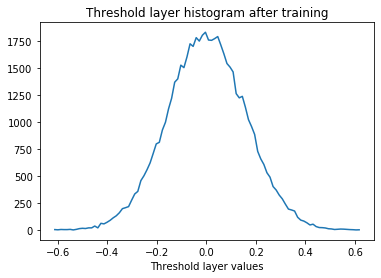

In [2]:
for idx, m in enumerate(model.block1.modules()):
    if idx == 4:
        #print(m.threshold1)
        plt.figure()
        thresh_hist = torch.histc(m.threshold1)
        start = np.min(m.threshold1.cpu().detach().numpy())
        end = np.max(m.threshold1.cpu().detach().numpy())
        xhist = torch.linspace(start,end,100) # histogram x-axis
        plt.plot(xhist, thresh_hist.cpu().detach().numpy())
        plt.title('Threshold layer histogram after training')
        plt.xlabel('Count')
        plt.xlabel('Threshold layer values')

In [3]:
'''  
The image lies between [0,1] but since I have trained the whole network on normalized input, Therefore
the min_val = -2.117 and max_val = 2.64 and not {0,1}
'''

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, -2.117, 2.64)
    # Return the perturbed image
    return perturbed_image

def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        #if init_pred.item() != target.item():
        #    continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        for i in range(0,len(final_pred)-1):
            if final_pred[i].sub(target[i]) == 0:
                correct += 1
                # Special case for saving 0 epsilon examples
                if (epsilon == 0) and (len(adv_examples) < 5):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[i], final_pred[i], adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[i], final_pred[i], adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [4]:
#evaluate model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print('Accuracy on the test dataset is: %f %%' % (
    100 * correct / total))

Accuracy on the test dataset is: 90.170000 %


In [5]:
accuracies1 = []
examples1 = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, testloader, eps)
    accuracies1.append(acc)
    examples1.append(ex)

Epsilon: 0	Test Accuracy = 8925 / 100 = 89.25
Epsilon: 0.05	Test Accuracy = 5698 / 100 = 56.98
Epsilon: 0.1	Test Accuracy = 5096 / 100 = 50.96
Epsilon: 0.15	Test Accuracy = 4829 / 100 = 48.29
Epsilon: 0.2	Test Accuracy = 4689 / 100 = 46.89
Epsilon: 0.25	Test Accuracy = 4520 / 100 = 45.2
Epsilon: 0.3	Test Accuracy = 4278 / 100 = 42.78


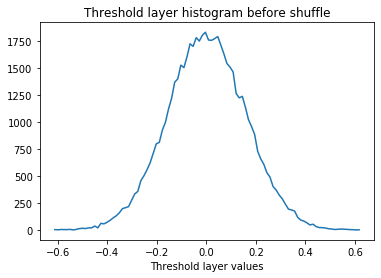

In [6]:
#Shuffle the threshold values

for idx, m in enumerate(model.block1.modules()):
    if idx == 4:
        #print(idx, '->', m)
        #i = torch.randperm(m.threshold1.nelement())
        i = torch.randperm(m.threshold1.nelement())
        m.threshold1.data = torch.nn.Parameter(m.threshold1.view(-1)[i].view(m.threshold1.size()))
        #m.threshold1 = torch.nn.Parameter(torch.empty(1, 64, 30, 30).normal_(0.5,std=0.1).cuda())
        #print(m.threshold1)
        
        plt.figure()
        thresh_hist = torch.histc(m.threshold1)
        start = np.min(m.threshold1.cpu().detach().numpy())
        end = np.max(m.threshold1.cpu().detach().numpy())
        xhist = torch.linspace(start,end,100) # histogram x-axis
        plt.plot(xhist, thresh_hist.cpu().detach().numpy())
        plt.title('Threshold layer histogram before shuffle')
        plt.ylabel('Count')
        plt.xlabel('Threshold layer values')

In [7]:
#evaluate model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print('Accuracy on the test dataset is: %f %%' % (
    100 * correct / total))

Accuracy on the test dataset is: 90.260000 %


In [8]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, testloader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 8933 / 100 = 89.33
Epsilon: 0.05	Test Accuracy = 5738 / 100 = 57.38
Epsilon: 0.1	Test Accuracy = 5097 / 100 = 50.97
Epsilon: 0.15	Test Accuracy = 4871 / 100 = 48.71
Epsilon: 0.2	Test Accuracy = 4684 / 100 = 46.84
Epsilon: 0.25	Test Accuracy = 4533 / 100 = 45.33
Epsilon: 0.3	Test Accuracy = 4273 / 100 = 42.73


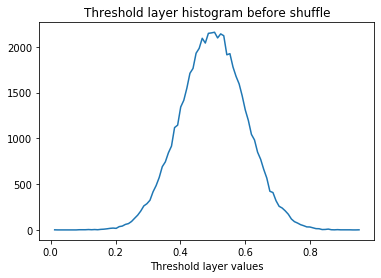

In [9]:
#Reinitilize the threshold values

for idx, m in enumerate(model.block1.modules()):
    if idx == 4:
        #print(idx, '->', m)
        #i = torch.randperm(m.threshold1.nelement())
        m.threshold1.data = torch.nn.Parameter(torch.empty(1, 64, 30, 30).normal_(0.5,std=0.1).cuda())
        #print(m.threshold1)
        
        plt.figure()
        thresh_hist = torch.histc(m.threshold1)
        start = np.min(m.threshold1.cpu().detach().numpy())
        end = np.max(m.threshold1.cpu().detach().numpy())
        xhist = torch.linspace(start,end,100) # histogram x-axis
        plt.plot(xhist, thresh_hist.cpu().detach().numpy())
        plt.title('Threshold layer histogram before shuffle')
        plt.xlabel('Count')
        plt.xlabel('Threshold layer values')

In [10]:
accuracies2 = []
examples2 = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, testloader, eps)
    accuracies2.append(acc)
    examples2.append(ex)

Epsilon: 0	Test Accuracy = 6191 / 100 = 61.91
Epsilon: 0.05	Test Accuracy = 2238 / 100 = 22.38
Epsilon: 0.1	Test Accuracy = 1704 / 100 = 17.04
Epsilon: 0.15	Test Accuracy = 1609 / 100 = 16.09
Epsilon: 0.2	Test Accuracy = 1632 / 100 = 16.32
Epsilon: 0.25	Test Accuracy = 1754 / 100 = 17.54
Epsilon: 0.3	Test Accuracy = 1909 / 100 = 19.09


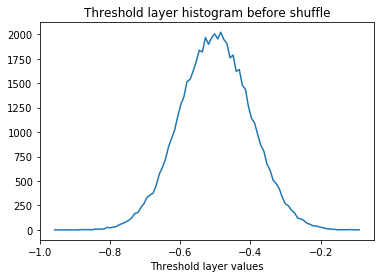

In [11]:
#Reinitilize the threshold values

for idx, m in enumerate(model.block1.modules()):
    if idx == 4:
        #print(idx, '->', m)
        #i = torch.randperm(m.threshold1.nelement())
        m.threshold1.data = torch.nn.Parameter(torch.empty(1, 64, 30, 30).normal_(-0.5,std=0.1).cuda())
        #print(m.threshold1)
        
        plt.figure()
        thresh_hist = torch.histc(m.threshold1)
        start = np.min(m.threshold1.cpu().detach().numpy())
        end = np.max(m.threshold1.cpu().detach().numpy())
        xhist = torch.linspace(start,end,100) # histogram x-axis
        plt.plot(xhist, thresh_hist.cpu().detach().numpy())
        plt.title('Threshold layer histogram before shuffle')
        plt.xlabel('Count')
        plt.xlabel('Threshold layer values')

In [12]:
accuracies3 = []
examples3 = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, testloader, eps)
    accuracies3.append(acc)
    examples3.append(ex)

Epsilon: 0	Test Accuracy = 8889 / 100 = 88.89
Epsilon: 0.05	Test Accuracy = 5664 / 100 = 56.64
Epsilon: 0.1	Test Accuracy = 5062 / 100 = 50.62
Epsilon: 0.15	Test Accuracy = 4821 / 100 = 48.21
Epsilon: 0.2	Test Accuracy = 4605 / 100 = 46.05
Epsilon: 0.25	Test Accuracy = 4330 / 100 = 43.3
Epsilon: 0.3	Test Accuracy = 4008 / 100 = 40.08


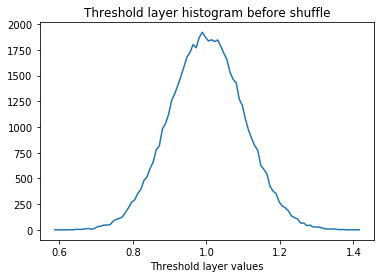

In [13]:
#Reinitilize the threshold values

for idx, m in enumerate(model.block1.modules()):
    if idx == 4:
        #print(idx, '->', m)
        #i = torch.randperm(m.threshold1.nelement())
        m.threshold1 = torch.nn.Parameter(torch.empty(1, 64, 30, 30).normal_(1,std=0.1).cuda())
        #print(m.threshold1)
        
        plt.figure()
        thresh_hist = torch.histc(m.threshold1)
        start = np.min(m.threshold1.cpu().detach().numpy())
        end = np.max(m.threshold1.cpu().detach().numpy())
        xhist = torch.linspace(start,end,100) # histogram x-axis
        plt.plot(xhist, thresh_hist.cpu().detach().numpy())
        plt.title('Threshold layer histogram before shuffle')
        plt.xlabel('Count')
        plt.xlabel('Threshold layer values')

In [14]:
accuracies4 = []
examples4 = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, testloader, eps)
    accuracies4.append(acc)
    examples4.append(ex)

Epsilon: 0	Test Accuracy = 1331 / 100 = 13.31
Epsilon: 0.05	Test Accuracy = 822 / 100 = 8.22
Epsilon: 0.1	Test Accuracy = 643 / 100 = 6.43
Epsilon: 0.15	Test Accuracy = 541 / 100 = 5.41
Epsilon: 0.2	Test Accuracy = 480 / 100 = 4.8
Epsilon: 0.25	Test Accuracy = 510 / 100 = 5.1
Epsilon: 0.3	Test Accuracy = 619 / 100 = 6.19


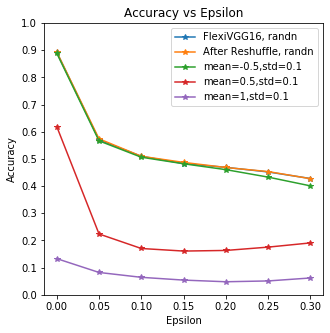

In [15]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, torch.tensor(accuracies1).div(100), "*-", label = "FlexiVGG16, randn")
plt.plot(epsilons, torch.tensor(accuracies).div(100), "*-", label = "After Reshuffle, randn")
plt.plot(epsilons, torch.tensor(accuracies3).div(100), "*-", label = "mean=-0.5,std=0.1")
plt.plot(epsilons, torch.tensor(accuracies2).div(100), "*-", label = "mean=0.5,std=0.1")
plt.plot(epsilons, torch.tensor(accuracies4).div(100), "*-", label = "mean=1,std=0.1")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

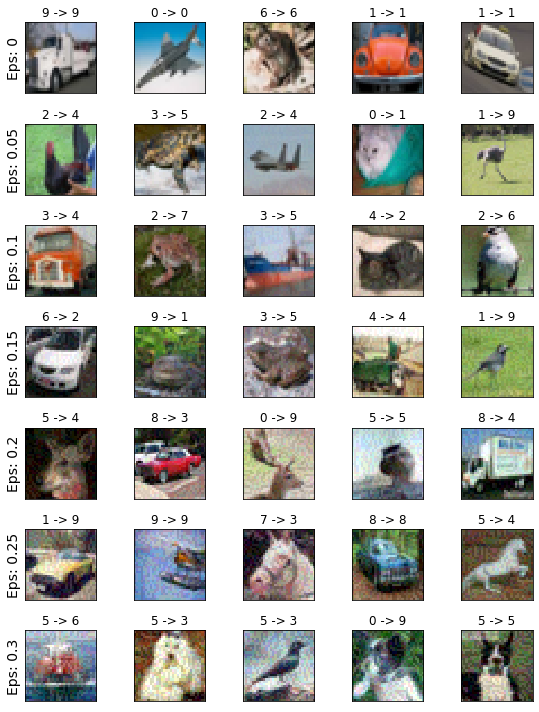

In [16]:
# Plot several examples of adversarial samples at each epsilon
def convert_cifar10(t,pil):
    """Function to convert a cifar10 image tensor (already normalized)
    onto a plotable image.
    
    :param t: image tensor of size (3,32,23)
    :type t: torch.Tensor
    :param pil: output is of size (3,32,32) if True, else (32,32,3)
    :type pil: bool
    """
    im = torch.tensor(t).clone()
    # approximate unnormalization 
    im[0] = im[0]*0.229 + 0.485
    im[1] = im[1]*0.224 + 0.456
    im[2] = im[2]*0.225 + 0.406
    if not pil:
        im = im.numpy()
        im = np.transpose(im,(1,2,0))
    return im

cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(int(orig), int(adv)))
        ex = convert_cifar10(ex[j],pil=False)
        plt.imshow(ex)
plt.tight_layout()
plt.show()

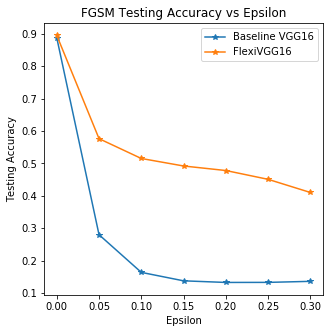

In [17]:
import matplotlib.pyplot as plt
import numpy as np

epsilons = [0, .05, .1, .15, .2, .25, .3]
accuracies1 = [0.8881, 0.2799, 0.1636, 0.1375, 0.1325, 0.1327, 0.1359]
accuracies2 = [0.8955, 0.5765, 0.5153, 0.4921, 0.4781, 0.4509, 0.4103] # trained over 150 epochs
#accuracies3 = [0.8859, 0.5146, 0.4343, 0.4052, 0.3878, 0.3729, 0.3536] # trained over 100 epochs
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies1, "*-", label = "Baseline VGG16")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.plot(epsilons, accuracies2, "*-", label = "FlexiVGG16")
plt.xticks(np.arange(0, .35, step=0.05))
#plt.plot(epsilons, accuracies3, "*-", label = "FlexiVGG16_batch_indep_100epochs")
plt.title("FGSM Testing Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Testing Accuracy")
plt.legend()
#plt.savefig('./figures/fgsm_testing_results.png', format='png')
plt.show()

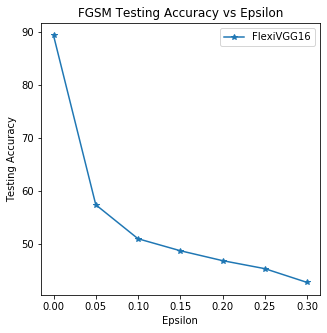

In [18]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-", label = "FlexiVGG16")
#plt.xticks(np.arange(0, .35, step=0.05))
plt.title("FGSM Testing Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Testing Accuracy")
plt.legend()
#plt.savefig('./figures/fgsm_testing_large_epsilon.png', format='png')
plt.show()